# Housing Prices: Advanced Regression


In [1]:
import random
import os
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [42]:
def encode_features(df_train, df_test):
    '''
    Takes columns whose values are strings (objects)
    and categorizes them into discrete numbers.
    This makes it feasible to use regression
    '''
    features = list(df_train.select_dtypes(include=['object']).columns)
    df_combined = pd.concat([df_train[features], df_test[features]])

    for feature in features:
        unique_categories = list(df_combined[feature].unique())
        map_dict = {}
        for idx, category in enumerate(unique_categories):
            map_dict[category] = idx + 1
        df_train[feature] = df_train[feature].map(map_dict)
        df_test[feature] = df_test[feature].map(map_dict)
    
    return df_train, df_test


def cleanup(df):
    '''
    Cleans data
        1. Creates new features:
            - total bathrooms = full + half bathrooms
            - total porch area = closed + open porch area
        2. Drops unwanted features
        3. Fills missing values with the mode
        4. Performs feature scaling
    '''
    to_drop = ['MiscFeature', 'MiscVal', 'GarageArea', 'GarageYrBlt', 'Street', 'Alley',
              'LotShape', 'LandContour', 'LandSlope', 'RoofMatl', 'Exterior2nd', 'MasVnrType',
              'MasVnrArea', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
              'BsmtFinSF1', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'Electrical',
              'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
              'HalfBath', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'FireplaceQu',
              'GarageType', 'GarageFinish', 'GarageQual', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
              'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolQC', 'MoSold']
    
    df['Bathrooms'] = df['FullBath'] + df['HalfBath']
    df['PorchSF'] = df['EnclosedPorch'] + df['OpenPorchSF']
    df = df.drop(to_drop, axis=1)
    
    to_ignore = ['SalePrice', 'Id']
    for column in df.columns:
        x = df[column].dropna().value_counts().index[0]
        df = df.fillna(x)
        if df[column].dtype != 'object' and column not in to_ignore:
            m = df[column].min()
            M = df[column].max()
            Range = M - m
            df[column] = (df[column] - m) / Range
    return df

In [53]:
data_dir = 'data'

train_dataset = pd.read_csv(os.path.join(data_dir, 'train.csv'))
test_dataset = pd.read_csv(os.path.join(data_dir, 'test.csv'))

train_dataset = cleanup(train_dataset)
test_dataset = cleanup(test_dataset)
train_dataset, test_dataset = encode_features(train_dataset, test_dataset)

In [4]:
# Shuffle data
train_dataset = train_dataset.sample(frac=1)
# Split into training, validation, and testing datasets
train, valid, test = np.split(train_dataset,
                        [int(.6 * len(train_dataset)), int(.8 * len(train_dataset))])

# Convert into numpy arrays
x_train = train.drop(['SalePrice', 'Id'], axis=1).as_matrix().astype(np.float32)
y_train = train['SalePrice'].as_matrix().astype(np.float32).reshape((np.shape(x_train)[0], 1))
x_test = test.drop(['SalePrice', 'Id'], axis=1).as_matrix().astype(np.float32)
y_test = test['SalePrice'].as_matrix().astype(np.float32).reshape((np.shape(x_test)[0], 1))
x_valid = valid.drop(['SalePrice', 'Id'], axis=1).as_matrix().astype(np.float32)
y_valid = valid['SalePrice'].as_matrix().astype(np.float32).reshape((np.shape(x_valid)[0], 1))

## Training with only Linear Regression

In [28]:
train_size = np.shape(x_train)[0]
valid_size = np.shape(x_valid)[0]
test_size = np.shape(x_test)[0]
num_features = np.shape(x_train)[1]

graph = tf.Graph()
with graph.as_default():
    
    # Input
    tf_train_dataset = tf.constant(x_train, dtype=tf.float32)
    tf_train_labels = tf.constant(y_train, dtype=tf.float32)
    tf_valid_dataset = tf.constant(x_valid)
    tf_test_dataset = tf.constant(x_test)
    
    # Variables
    weights = tf.Variable(tf.truncated_normal([num_features, 1]), dtype=tf.float32, name="weights")
    biases = tf.Variable(tf.zeros([1]), dtype=tf.float32, name="biases")
    
    # Loss Computation
    train_prediction = tf.matmul(tf_train_dataset, weights) + biases
    loss = 0.5 * tf.reduce_mean(tf.squared_difference(tf_train_labels, train_prediction))
    cost = tf.sqrt(loss)
    
    # Optimizer
    # Gradient descent optimizer with learning rate = alpha
    alpha = tf.constant(0.01, dtype=tf.float64)
    optimizer = tf.train.GradientDescentOptimizer(alpha).minimize(loss)
    
    # Predictions
    valid_prediction = tf.matmul(tf_valid_dataset, weights) + biases
    test_prediction = tf.matmul(tf_test_dataset, weights) + biases
    
    saver = tf.train.Saver()

In [29]:
num_steps = 100001

def accuracy(prediction, labels):
    return 0.5 * np.sqrt(((prediction - labels) ** 2).mean(axis=None))

with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        # Run the computations. We tell .run() that we want to run the optimizer,
        # and get the loss value and the training predictions returned as numpy
        # arrays.
        _, c, predictions = sess.run([optimizer, cost, train_prediction])
        if (step % 5000 == 0):
            print('Cost at step %d: %f' % (step, c))
            # Calling .eval() on valid_prediction is basically like calling run(), but
            # just to get that one numpy array. Note that it recomputes all its graph
            # dependencies.
            print('Validation loss: %.2f' % accuracy(valid_prediction.eval(), y_valid))
        t_pred = test_prediction.eval()
    print('Test loss: %.2f' % accuracy(t_pred, y_test))
    save_path = saver.save(sess, "./model/linear-model.ckpt")
    print('Model saved in %s' % (save_path))

Initialized
Cost at step 0: 140858.640625
Validation loss: 90895.81
Cost at step 5000: 27133.974609
Validation loss: 22309.54
Cost at step 10000: 25634.763672
Validation loss: 21676.43
Cost at step 15000: 24824.152344
Validation loss: 21490.71
Cost at step 20000: 24314.023438
Validation loss: 21474.38
Cost at step 25000: 23961.642578
Validation loss: 21532.43
Cost at step 30000: 23703.333984
Validation loss: 21625.25
Cost at step 35000: 23507.050781
Validation loss: 21733.69
Cost at step 40000: 23354.685547
Validation loss: 21847.53
Cost at step 45000: 23234.908203
Validation loss: 21961.04
Cost at step 50000: 23140.025391
Validation loss: 22070.88
Cost at step 55000: 23064.503906
Validation loss: 22175.15
Cost at step 60000: 23004.162109
Validation loss: 22272.90
Cost at step 65000: 22955.878906
Validation loss: 22363.58
Cost at step 70000: 22917.148438
Validation loss: 22447.17
Cost at step 75000: 22886.027344
Validation loss: 22523.79
Cost at step 80000: 22860.982422
Validation loss

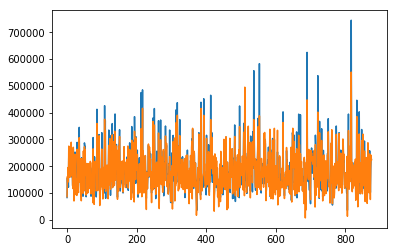

In [30]:
plt.plot(y_train)
plt.plot(predictions)
plt.show()

In [54]:
# Restore model and make predictions

with tf.Session(graph=graph) as sess:
    saver.restore(sess, "./model/linear-model.ckpt")
    print("Model restored.\nMaking predictions...")
    x = test_dataset.drop('Id', axis=1).as_matrix().astype(dtype=np.float32)
    y = tf.cast((tf.matmul(x, weights) + biases), dtype=tf.uint16).eval()
    test_dataset['SalePrice'] = y
    output = test_dataset[['Id', 'SalePrice']]

INFO:tensorflow:Restoring parameters from ./model/linear-model.ckpt
Model restored.
Making predictions...


In [56]:
print(output.head())
output.to_csv('./submissions/linear-submission.csv', index=False)

     Id  SalePrice
0  1461      18635
1  1462        321
2  1463      23577
3  1464      41981
4  1465      11400


This model ranked me at position `1868` with a score of `2.5804`. There is great room for improvement in this relatively simple model. Here are a few changes that could be made:
1. Using the difference in log of labels and predictions to calculate the cost can treat the errors in predicting expensive and cheap houses equally
2. Using regularization
3. Incorporating other features that I dropped earlier

## Training with Neural Networks and Regression